## Importing libraries

In [125]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns

######preprocessing text######

#regular expressions for preprocessing text
import re

#manipulating contractions in text
from pycontractions import Contractions

# custom script
from preprocessing import remove_hashtags, ReplaceThreeOrMore

#deemojize
import emoji

#lemmatization
from textblob import Word



from sklearn import preprocessing
#encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#tokenization
from keras.preprocessing.text import Tokenizer

from keras.utils import to_categorical

import random

#modeling

from keras import models
from keras import layers
from keras.layers import Lambda, Dense, Dropout
from keras.callbacks import  EarlyStopping

# to save model
import pickle
from keras.models import Sequential, model_from_json


import sqlite3

# #for word embedding
# ModelCheckpoint,
# import pydot





# from wordsegment import load, segment
# import codecs
# import unidecode

# import spacy
# nlp = spacy.load('en_core_web_sm')


# import textblob
# from textblob import TextBlob

# import nltk
# from nltk.corpus import stopwords



# from keras.models import load_model
# from keras.models import model_from_json

# from keras import backend as K
# from keras.layers.convolutional import Convolution1D



# import keras
# import keras.utils


# import matplotlib.pyplot as plt
# %matplotlib inline

## Import Data

In [2]:
conn = sqlite3.connect( r"./data/emotion.db")
c = conn.cursor()

In [3]:
twitter_df = pd.read_sql_query("SELECT text,emotion FROM emotions;", conn)

In [40]:
counts = pd.read_sql_query("""SELECT emotion, count(emotion) as count 
                            FROM emotions
                            GROUP BY emotion
                            ORDER BY count DESC;""", conn)

In [41]:
counts

,emotion,count
0,joy,386601
1,sadness,330432
2,anger,291480
3,love,167715
4,thankfulness,78228
5,fear,72094
6,surprise,13244


In [36]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339794 entries, 0 to 1339793
Data columns (total 2 columns):
text       1339794 non-null object
emotion    1339794 non-null object
dtypes: object(2)
memory usage: 20.4+ MB


In [37]:
twitter_df.shape

(1339794, 2)

In [38]:
twitter_df.head()

,text,emotion
0,"Be gentle with yourself for we all fall down, ...",love
1,Weeding out negative thoughts allows inspirati...,love
2,"There is a great divine plan to everything, ev...",love
3,i was asked a question.: What am i more afraid...,love
4,A #Libra doesn't play with #love,love


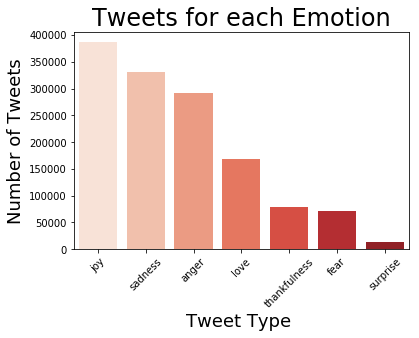

In [63]:
ax = sns.barplot(x='emotion',
                 y='count',
                 data=counts,
                 palette = 'Reds'
                 
                 )
plt.title("Tweets for each Emotion", fontsize=24)
plt.ylabel('Number of Tweets', fontsize=18)
plt.xlabel('Tweet Type ', fontsize=18 )
plt.xticks(rotation=45)
plt.show()

## Undersampling 

- Will select the emotions fear, anger, joy, and sadness. 
- fear label has the smallest amount (~72k) of records
- Will select 80k random records for the other three labels 

In [69]:
fear = twitter_df.loc[twitter_df.emotion == 'fear'].reset_index()
fear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72094 entries, 0 to 72093
Data columns (total 3 columns):
index      72094 non-null int64
text       72094 non-null object
emotion    72094 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [70]:
joy = pd.read_sql_query("""SELECT text, emotion  
                        FROM emotions 
                        WHERE emotion = 'joy'
                        ORDER BY RANDOM() LIMIT 80000;""", conn)
joy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
text       80000 non-null object
emotion    80000 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


In [71]:
anger = pd.read_sql_query("""SELECT text, emotion  
                        FROM emotions 
                        WHERE emotion = 'anger'
                        ORDER BY RANDOM() LIMIT 80000;""", conn)
anger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
text       80000 non-null object
emotion    80000 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


In [72]:
sadness = pd.read_sql_query("""SELECT text, emotion  
                        FROM emotions 
                        WHERE emotion = 'sadness'
                        ORDER BY RANDOM() LIMIT 80000;""", conn)
sadness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
text       80000 non-null object
emotion    80000 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


In [86]:
twitter_df = pd.concat([sadness, fear, joy, anger], axis = 0 , sort = True).drop(columns ='index')

In [87]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312094 entries, 0 to 79999
Data columns (total 2 columns):
emotion    312094 non-null object
text       312094 non-null object
dtypes: object(2)
memory usage: 7.1+ MB


In [88]:
twitter_df.to_sql("emotions_subset", conn, if_exists="append" , index = False)
conn.commit()

In [89]:
counts = pd.read_sql_query("""SELECT emotion, count(emotion) as count 
                            FROM emotions_subset
                            GROUP BY emotion
                            ORDER BY count DESC;""", conn)

In [90]:
counts

,emotion,count
0,anger,80000
1,joy,80000
2,sadness,80000
3,fear,72094


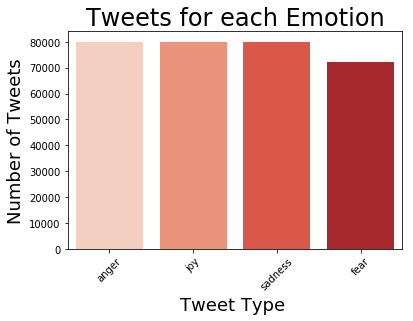

In [91]:
ax = sns.barplot(x='emotion',
                 y='count',
                 data=counts,
                 palette = 'Reds'
                 
                 )
plt.title("Tweets for each Emotion", fontsize=24)
plt.ylabel('Number of Tweets', fontsize=18)
plt.xlabel('Tweet Type ', fontsize=18 )
plt.xticks(rotation=45)
plt.show()

## Preprocessing

In [126]:
#create new column to have clean text
twitter_df['clean_text'] = twitter_df['text']

__Remove Usernames__

In [127]:
#removing usernames
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: re.sub('@[\w]*', "", x))

In [128]:
pd.set_option('display.max_colwidth', -1)
twitter_df.head()

,emotion,text,clean_text
0,sadness,I guess we're not meant to be huh :( #sad,I guess we're not meant to be huh :( #sad
1,sadness,When traditions are broken #sad,When traditions are broken #sad
2,sadness,@MarieAllie_29 i don't believe you would want someone to go to hell knowing you actually know Jesus died for whoever that person is. #sad,i don't believe you would want someone to go to hell knowing you actually know Jesus died for whoever that person is. #sad
3,sadness,can't wait to go back to Pittsburgh for Christmas.\n#homesick,can't wait to go back to Pittsburgh for Christmas.\n#homesick
4,sadness,Watching Gracie! Really wish @alexissterkel or @oliviahudson86 would come over! #lonely :(,Watching Gracie! Really wish or would come over! #lonely :(


__Remove Hashtags__

In [130]:
#remove hashtag from clean text
twitter_df['clean_text'] = remove_hashtags(twitter_df['clean_text'] )

__Handle Emojis__

In [131]:
# de-emojizing 
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: emoji.demojize(x))

__Handle Contractions__

In [132]:
cont = Contractions(api_key="glove-twitter-100")
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: list(cont.expand_texts([x])))
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: str(x))

In [133]:
pd.set_option('display.max_colwidth', -1)
twitter_df.head()

,emotion,text,clean_text
0,sadness,I guess we're not meant to be huh :( #sad,['I guess we are not meant to be huh :( ']
1,sadness,When traditions are broken #sad,['When traditions are broken ']
2,sadness,@MarieAllie_29 i don't believe you would want someone to go to hell knowing you actually know Jesus died for whoever that person is. #sad,[' i do not believe you would want someone to go to hell knowing you actually know Jesus died for whoever that person is. ']
3,sadness,can't wait to go back to Pittsburgh for Christmas.\n#homesick,['cannot wait to go back to Pittsburgh for Christmas.\n']
4,sadness,Watching Gracie! Really wish @alexissterkel or @oliviahudson86 would come over! #lonely :(,['Watching Gracie! Really wish or would come over! :(']


__Remove links,html tags and other characters__

In [135]:
#removing links to websites
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: re.sub(r"http\S+", "", x))
#remove html characters
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: x.replace('&amp',''))
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: x.replace('\n',''))
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: x.replace('á',''))
#remove punctuation
twitter_df['clean_text'] = twitter_df['clean_text'].str.replace('[^\w\s]',' ')
# twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: x.replace('[',''))
# twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: x.replace(']',''))
# twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: x.replace("'",''))

In [140]:
pd.set_option('display.max_colwidth', -1)
twitter_df.head()

,emotion,text,clean_text
0,sadness,I guess we're not meant to be huh :( #sad,I guess we are not meant to be huh
1,sadness,When traditions are broken #sad,When traditions are broken
2,sadness,@MarieAllie_29 i don't believe you would want someone to go to hell knowing you actually know Jesus died for whoever that person is. #sad,i do not believe you would want someone to go to hell knowing you actually know Jesus died for whoever that person is
3,sadness,can't wait to go back to Pittsburgh for Christmas.\n#homesick,cannot wait to go back to Pittsburgh for Christmas n
4,sadness,Watching Gracie! Really wish @alexissterkel or @oliviahudson86 would come over! #lonely :(,Watching Gracie Really wish or would come over


__Remove characters repeated more than 2 times__

In [143]:
#remove characters repeated more than 2 times
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: ReplaceThreeOrMore(x))

__Removing Numbers__

In [142]:
#removing numbers
twitter_df['clean_text']  = twitter_df['clean_text'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))

__Set to lowercase__

In [144]:
#set to lowercase
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [147]:
#lemmatization
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: str(x))
twitter_df['clean_text'] = twitter_df['clean_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [148]:
pd.set_option('display.max_colwidth', -1)
twitter_df.head()

,emotion,text,clean_text
0,sadness,I guess we're not meant to be huh :( #sad,i guess we are not meant to be huh
1,sadness,When traditions are broken #sad,when tradition are broken
2,sadness,@MarieAllie_29 i don't believe you would want someone to go to hell knowing you actually know Jesus died for whoever that person is. #sad,i do not believe you would want someone to go to hell knowing you actually know jesus died for whoever that person is
3,sadness,can't wait to go back to Pittsburgh for Christmas.\n#homesick,cannot wait to go back to pittsburgh for christmas n
4,sadness,Watching Gracie! Really wish @alexissterkel or @oliviahudson86 would come over! #lonely :(,watching gracie really wish or would come over


In [149]:
#saving preprocessed data for any future rerun
twitter_df.to_sql("emotions_preprocessed", conn, if_exists='replace' , index = False)
conn.commit()

In [150]:
conn.close()